<a href="https://colab.research.google.com/github/wisemanam/NIHLungNet/blob/main/final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecting Lung Disease Using CNNs

In [1]:
%matplotlib inline

import os
import numpy as np
import tensorflow as tf
!pip install tensorflow_addons
import tensorflow_addons as tfa
import pandas as pd
import keras
from keras.applications import DenseNet121
from keras.applications.densenet import preprocess_input
from keras.models import Model
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import CategoricalCrossentropy
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.metrics import AUC


     |████████████████████████████████| 706kB 4.3MB/s 


## Loading in the Data

In [3]:
data_path = '/content/drive/MyDrive/data/xray_data/'
train_path = data_path + 'train/'
test_path = data_path + 'test/'

In [4]:
df = pd.read_csv(data_path + "Data_Entry_2017.csv")
df["Finding Labels"]=df["Finding Labels"].apply(lambda x:x.split("|"))
classes = ["No Finding", 
           "Atelectasis", 
           "Consolidation", 
           "Infiltration",
           "Pneumothorax",
           "Edema",
           "Emphysema",
           "Fibrosis",
           "Effusion",
           "Pneumonia",
           "Pleural_Thickening",
           "Cardiomegaly",
           "Mass",
           "Nodule",
           "Hernia"]

datagen=ImageDataGenerator(rescale=1./255.)
test_datagen=ImageDataGenerator(rescale=1./255.)

# using 15000/86524 training images
train_it=datagen.flow_from_dataframe(dataframe=df, 
                                            directory=train_path, 
                                            x_col="Image Index", 
                                            y_col="Finding Labels", 
                                            batch_size=32, 
                                            seed=42, 
                                            shuffle=True, 
                                            class_mode="categorical",
                                            classes=classes,
                                            target_size=(1024,1024))

# using 2000/~20000 testing images
test_it=test_datagen.flow_from_dataframe(dataframe=df,
                                                directory=test_path,
                                                x_col="Image Index",
                                                y_col="Finding Labels",
                                                batch_size=1,
                                                seed=42,
                                                shuffle=False,
                                                class_mode="categorical",
                                                classes=classes,
                                                target_size=(1024,1024))

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 89061 invalid image filename(s) in x_col="Image Index". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 23059 validated image filenames belonging to 15 classes.
Found 3210 validated image filenames belonging to 15 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 108910 invalid image filename(s) in x_col="Image Index". These filename(s) will be ignored.
  .format(n_invalid, x_col)


## Creating the Model
Next, I am going to create the model that will train on the Chest X-Rays. I am going to start with a pre-trained network and see if that helps training go more smoothly. I am using categorical crossentropy as my loss function to allow for multiple labels being present. I also use sigmoid activation to accommodate multiple labels. 

In [5]:
from tensorflow_addons.metrics import HammingLoss
# load model without classifier layers
model = DenseNet121(include_top=False, input_shape=(1024, 1024, 3), weights='imagenet', pooling='max')

# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(1024, activation='relu')(flat1)
dropout = Dropout(0.2)(class1)
output = Dense(15, activation='sigmoid')(class1)

# define new model
model = Model(inputs=model.inputs, outputs=output)

for layer in model.layers[:-4]:
    layer.trainable=False

optimizer = keras.optimizers.Adam(lr=0.00001)
metric = AUC(multi_label=True)
model.compile(loss=[tfa.losses.SigmoidFocalCrossEntropy(gamma=4.0)], metrics=[metric], optimizer=optimizer)
history1 = model.fit(train_it, batch_size=256, epochs=10, validation_data=test_it)


29089792/29084464 [==============================] - 0s 0us/step
Epoch 1/10
721/721 [==============================] - 32126s 45s/step - loss: 2.7719 - auc: 0.5133 - val_loss: 0.6220 - val_auc: 0.5144
Epoch 2/10
721/721 [==============================] - 820s 1s/step - loss: 0.3640 - auc: 0.5309 - val_loss: 0.5140 - val_auc: 0.5197
Epoch 3/10
721/721 [==============================] - 811s 1s/step - loss: 0.3001 - auc: 0.5282 - val_loss: 0.4422 - val_auc: 0.5219
Epoch 4/10
721/721 [==============================] - 812s 1s/step - loss: 0.2528 - auc: 0.5485 - val_loss: 0.3990 - val_auc: 0.5235
Epoch 5/10
721/721 [==============================] - 808s 1s/step - loss: 0.2249 - auc: 0.5571 - val_loss: 0.3718 - val_auc: 0.5276
Epoch 6/10
721/721 [==============================] - 804s 1s/step - loss: 0.2023 - auc: 0.5539 - val_loss: 0.3375 - val_auc: 0.5316
Epoch 7/10
721/721 [==============================] - 810s 1s/step - loss: 0.1842 - auc: 0.5704 - val_loss: 0.3054 - val_auc: 0.5343
E

In [6]:
model.save('name.h5')

In [8]:
model.evaluate(test_it)

3210/3210 [==============================] - 126s 39ms/step - loss: 0.2552 - auc: 0.5403


[0.2551884055137634, 0.5403446555137634]

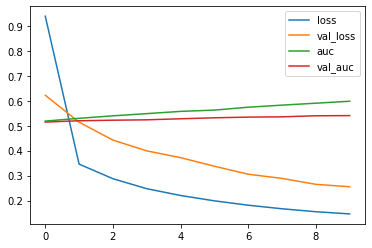

In [9]:
plt.plot( history1.epoch,history1.history['loss'], label = 'loss' )
plt.plot( history1.epoch,history1.history['val_loss'], label = 'val_loss' )
plt.legend()

plt.plot( history1.epoch,history1.history['auc'], label = 'auc' )
plt.plot( history1.epoch,history1.history['val_auc'], label = 'val_auc' )
plt.legend()

In [ ]:
test_it=test_datagen.flow_from_dataframe(dataframe=df,
                                                directory=test_path,
                                                x_col="Image Index",
                                                y_col="Finding Labels",
                                                batch_size=30,
                                                seed=42,
                                                shuffle=False,
                                                class_mode="categorical",
                                                classes=classes,
                                                target_size=(1024,1024))

def get_batch_scores(labels, pred_labels):
  batch_size = len(labels)
  num_classes = len(labels[0])

  accuracy_sum = 0
  precision_sum = 0
  recall_sum = 0

  accuracy_by_class = []
  precision_by_class = []
  recall_by_class = []

  for j in range(num_classes): # for each class
    tp_count = 0
    fn_count = 0
    fp_count = 0
    num_correct = 0
    for i in range(batch_size): # for each image in batch
      # counts number of correct predictions
      if pred_labels[i][j] == labels[i][j]:
        num_correct += 1

      # counts number of true positives
      if pred_labels[i][j] == 1 and labels[i][j] == 1:
        tp_count += 1

      # counts number of false negatives
      elif pred_labels[i][j] == 0 and labels[i][j] == 1:
        fn_count += 1
      
      # counts number of false positives
      elif pred_labels[i][j] == 1 and labels[i][j] == 0:
        fp_count += 1

    # gets the sum of all the scores in the batch
    accuracy_sum += num_correct/15
    if (tp_count + fp_count) != 0:
      precision_sum += tp_count/(tp_count + fp_count)
    if (tp_count + fn_count) != 0:
      recall_sum += tp_count/(tp_count + fn_count)

    # averages the score across the batch by dividing by the batch size
    accuracy_by_class.append(accuracy_sum/batch_size)
    precision_by_class.append(precision_sum/batch_size)
    recall_by_class.append(recall_sum/batch_size)

  # returns average scores across the batch
  return np.array(accuracy_by_class), np.array(precision_by_class), np.array(recall_by_class)

Found 3210 validated image filenames belonging to 15 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 108910 invalid image filename(s) in x_col="Image Index". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [ ]:
accuracies = []
precisions = []
recalls = []

for c, batch in enumerate(test_it):
  print('batch', c, '/' , '107')
  labels = batch[1]
  pred = model.predict(batch[0])
  pred_labels = 1*(pred>0.5)

  # gets average scores from the batch
  batch_accuracy, batch_precision, batch_recall = get_batch_scores(labels, pred_labels) 
  accuracies.append(batch_accuracy)
  precisions.append(batch_precision)
  recalls.append(batch_recall)

# averages the scores of all the batches
accuracies = np.mean(np.array(accuracies), axis=2)
precisions = np.mean(np.array(precisions), axis=2)
recalls = np.mean(np.array(recalls), axis=2)

print('Accuracy: ', accuracies)
print('Precision: ', precisions)
print('Recall: ', recalls)


batch 0 / 107
batch 1 / 107
batch 2 / 107
batch 3 / 107
batch 4 / 107
batch 5 / 107
batch 6 / 107
batch 7 / 107
batch 8 / 107
batch 9 / 107
batch 10 / 107
batch 11 / 107
batch 12 / 107
batch 13 / 107
batch 14 / 107
batch 15 / 107
batch 16 / 107
batch 17 / 107
batch 18 / 107
batch 19 / 107
batch 20 / 107
batch 21 / 107
batch 22 / 107
batch 23 / 107
batch 24 / 107
batch 25 / 107
batch 26 / 107
batch 27 / 107
batch 28 / 107
batch 29 / 107
batch 30 / 107
batch 31 / 107
batch 32 / 107
batch 33 / 107
batch 34 / 107
batch 35 / 107
batch 36 / 107
batch 37 / 107
batch 38 / 107
batch 39 / 107
batch 40 / 107
batch 41 / 107
batch 42 / 107
batch 43 / 107
batch 44 / 107
batch 45 / 107
batch 46 / 107
batch 47 / 107
batch 48 / 107
batch 49 / 107
batch 50 / 107
batch 51 / 107
batch 52 / 107
batch 53 / 107
batch 54 / 107
batch 55 / 107
batch 56 / 107
batch 57 / 107
batch 58 / 107
batch 59 / 107
batch 60 / 107
batch 61 / 107
batch 62 / 107
batch 63 / 107
batch 64 / 107
batch 65 / 107
batch 66 / 107
batch